

Your task is to beat all benchmarks in this competition. Here you won’t be provided with detailed instructions. Hopefully, at this stage of the course, it's enough for you to take a quick look at the data in order to understand that this is the type of task where gradient boosting will do. Most likely it will be LightGBM. But you can try Xgboost or Catboost as well.

<img src="https://habrastorage.org/webt/fs/42/ms/fs42ms0r7qsoj-da4x7yfntwrbq.jpeg" width=30% />

In [70]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

In [71]:
train_df = pd.read_csv('flight_delays_train.csv')
test_df = pd.read_csv('flight_delays_test.csv')

In [72]:
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [73]:
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


In [74]:
train_df['Month'] = train_df['Month'].map(lambda x: x.lstrip('c-'))
train_df['DayofMonth'] = train_df['DayofMonth'].map(lambda x: x.lstrip('c-'))
train_df['DayOfWeek'] = train_df['DayOfWeek'].map(lambda x: x.lstrip('c-'))

In [75]:
test_df['Month'] = test_df['Month'].map(lambda x: x.lstrip('c-'))
test_df['DayofMonth'] = test_df['DayofMonth'].map(lambda x: x.lstrip('c-'))
test_df['DayOfWeek'] = test_df['DayOfWeek'].map(lambda x: x.lstrip('c-'))

In [76]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
Month                100000 non-null object
DayofMonth           100000 non-null object
DayOfWeek            100000 non-null object
DepTime              100000 non-null int64
UniqueCarrier        100000 non-null object
Origin               100000 non-null object
Dest                 100000 non-null object
Distance             100000 non-null int64
dep_delayed_15min    100000 non-null object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


In [77]:
train_df['Month'] = train_df['Month'].astype(str).astype(int)
train_df['DayofMonth'] = train_df['DayofMonth'].astype(str).astype(int)
train_df['DayOfWeek'] = train_df['DayOfWeek'].astype(str).astype(int)

In [78]:
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,8,21,7,1934,AA,ATL,DFW,732,N
1,4,20,3,1548,US,PIT,MCO,834,N
2,9,2,5,1422,XE,RDU,CLE,416,N
3,11,25,6,1015,OO,DEN,MEM,872,N
4,10,7,6,1828,WN,MDW,OMA,423,Y


In [79]:
train_df['dep_delayed_15min'] = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values

In [105]:
train_df['UniqueCarrier'].value_counts()

WN    15082
AA     9418
DL     8128
MQ     7443
OO     7390
UA     6876
US     6482
NW     6403
XE     5901
OH     4594
CO     4334
EV     3930
FL     3039
AS     2222
YV     2128
B6     1838
HP     1378
F9     1006
DH      966
HA      762
TZ      446
AQ      234
Name: UniqueCarrier, dtype: int64

In [122]:
train_df['flight']=train_df['Origin']+'-'+train_df['Dest']
test_df['flight']=test_df['Origin']+'-'+test_df['Dest']

In [123]:
flights = pd.DataFrame()
flights['tr_flight'] = train_df['flight']
flights['te_flight'] = test_df['flight']
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
labelenc = LabelEncoder()
df = flights.apply(labelenc.fit_transform)

In [124]:
train_df['flight']=df['tr_flight']
test_df['flight']=df['te_flight']
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,flight
0,7,25,3,615,YV,MRY,PHX,598,2975
1,4,17,2,739,WN,LAS,HOU,1235,2320
2,12,2,7,651,MQ,GSP,ORD,577,1813
3,3,25,7,1614,WN,BWI,MHT,377,651
4,6,6,3,1505,UA,ORD,STL,258,3427


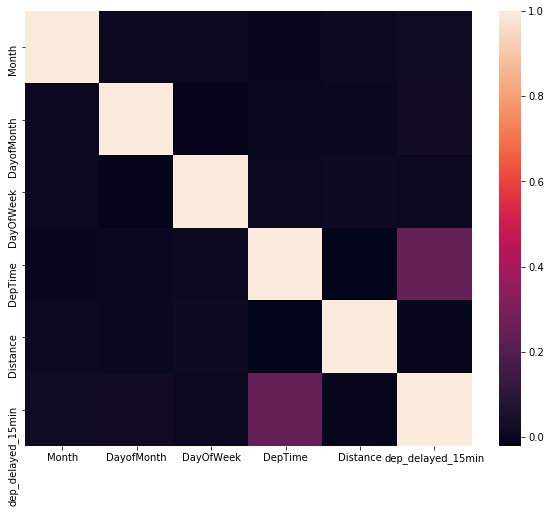

In [80]:
plt.figure(figsize=(10, 8))
sns.heatmap(train_df.corr());

Given flight departure time, carrier's code, departure airport, destination location, and flight distance, you have to predict departure delay for more than 15 minutes. As the simplest benchmark, let's take logistic regression and two features that are easiest to take: DepTime and Distance. This will correspond to **"simple logit baseline"** on Public LB.

In [130]:
X_train, y_train = train_df[['Month','DayofMonth','DayOfWeek','Distance', 'DepTime','flight']].values, train_df['dep_delayed_15min']  
X_test = test_df[['Month','DayofMonth','DayOfWeek','Distance', 'DepTime','flight']].values

X_train_part, X_valid, y_train_part, y_valid = \
    train_test_split(X_train, y_train, 
                     test_size=0.3, random_state=17)

In [131]:
logit_pipe = Pipeline([('scaler', StandardScaler()),
                       ('logit', LogisticRegression(C=1, random_state=17, solver='liblinear'))])

In [132]:
logit_pipe.fit(X_train_part, y_train_part)
logit_valid_pred = logit_pipe.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, logit_valid_pred)

0.6808799866384032

In [133]:
logit_pipe.fit(X_train, y_train)
logit_test_pred = logit_pipe.predict_proba(X_test)[:, 1]

pd.Series(logit_test_pred, 
          name='dep_delayed_15min').to_csv('logit_feat.csv', 
                                           index_label='id', header=True)

In [125]:
X_train, y_train = train_df[['Month','DayofMonth','DayOfWeek','Distance', 'DepTime','flight']].values, train_df['dep_delayed_15min']  #.map({'Y': 1, 'N': 0}).values
X_test = test_df[['Month','DayofMonth','DayOfWeek','Distance', 'DepTime','flight']].values

X_train_part, X_valid, y_train_part, y_valid = \
    train_test_split(X_train, y_train, 
                     test_size=0.3, random_state=17)

In [126]:
X_valid.shape

(30000, 6)

In [127]:
xgb_pipe = Pipeline([('scaler', StandardScaler()),
                       ('xgb', XGBClassifier(seed=17))])

In [128]:
xgb_pipe.fit(X_train_part, y_train_part)
xgb_valid_pred = xgb_pipe.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, xgb_valid_pred)

0.71335746569245

In [129]:
xgb_pipe.fit(X_train, y_train)
xgb_test_pred = xgb_pipe.predict_proba(X_test)[:, 1]

pd.Series(xgb_test_pred, 
          name='dep_delayed_15min').to_csv('xgb_6feat.csv', 
                                           index_label='id', header=True)

Now you have to beat **"A10 benchmark"** on Public LB. It's not challenging at all. Go for LightGBM, maybe some other models (or ensembling) as well. Include categorical features, do some simple feature engineering as well. Good luck!

If you think this course is worth spreading, you can do a favour:
* upvote this [announcement](https://www.kaggle.com/general/68205) on Kaggle Forum; optionally, tell your story threin
* upvote the mlcourse.ai [Kaggle Dataset](https://www.kaggle.com/kashnitsky/mlcourse), it'll pull the Dataset up in the list of all datasets
* upvoting course [Kernels](https://www.kaggle.com/kashnitsky/mlcourse/kernels?sortBy=voteCount&group=everyone&pageSize=20&datasetId=32132) is also a nice thing to do 
* spread a word on [mlcourse.ai](https://mlcourse.ai) in social networks, the next session is planned to launch in February 2019